In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import naive_bayes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import wordcloud
from sklearn import metrics

In [2]:
# 载入数据
df = pd.read_csv("data.csv")  # 数据采集时间是：2020.01.06
df.head()  # 查看数据前五行

,vote,user,user_url,star,level,release_time,content
0,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,2020-01-06,喜欢那个打黑拳！！
1,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,2020-01-06,还可以吧。
2,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,2020-01-06,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...
3,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020-01-06,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。
4,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,2020-01-06,适合消遣看看，破梗废话太多……


vote              0
user              0
user_url          0
star            263
level           263
release_time    263
content           0
dtype: int64


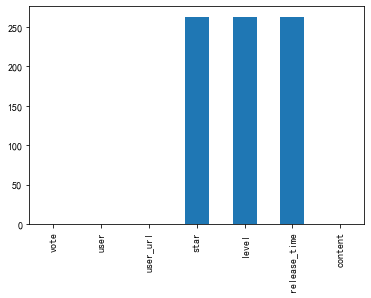

In [3]:
# 检查缺失值
# 缺失值是表中缺少的信息，参见：https://baike.baidu.com/item/%E7%BC%BA%E5%A4%B1%E5%80%BC/2336661?fr=aladdin
# 这里图中展示了star,level,release_time 这四个字段存在缺失值 
print(df.isnull().sum(axis=0))
df.isnull().sum(axis=0).plot.bar()

In [4]:
# 查看各个字段的类型
df.dtypes

vote              int64
user             object
user_url         object
star            float64
level            object
release_time     object
content          object
dtype: object

In [5]:
# 删除缺失值
df = df.dropna()
# 将时间字段的类型由之前的默认字符串类型转换为 datetime 类型
df["release_time"] = pd.to_datetime(df["release_time"])
df.dtypes  # 可以看到 release_time 已经转为了 datetime 类型

vote                     int64
user                    object
user_url                object
star                   float64
level                   object
release_time    datetime64[ns]
content                 object
dtype: object

In [6]:
# 把时间字段 release_time 设置为索引，便于后续使用 release_time 进行据合和绘图
df = df.set_index("release_time")
df.head()

,vote,user,user_url,star,level,content
release_time,,,,,,
2020-01-06,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,喜欢那个打黑拳！！
2020-01-06,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,还可以吧。
2020-01-06,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...
2020-01-06,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。
2020-01-06,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,适合消遣看看，破梗废话太多……


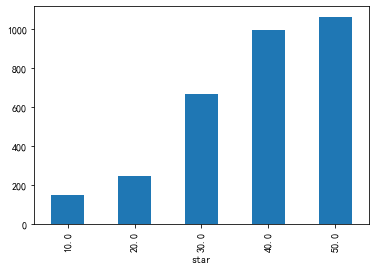

In [7]:
# 绘制评分等级条形图，展示不同评分的数值的人数
df.groupby("star")["star"].count().plot.bar()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x122891b38>],
      dtype=object)

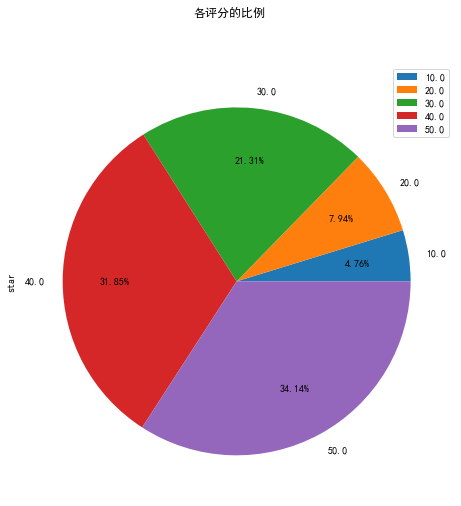

In [8]:
# 40~50 分占比超过了一半占了 65%
df.groupby("star")["star"].count().plot.pie(figsize=(8, 8), subplots=True, autopct="%.2f%%",
                    legend=True, title="各评分的比例", labeldistance=1.1,pctdistance=0.7)

In [9]:
# 将用户评论数量排序，查看是否某些用户由刷评论的行为
# 去掉已注销的用户，评论最多的用户名评论了三条
df.groupby("user")["user"].count().sort_values(ascending=False)[:20]

user
[已注销]     60
已注销       12
Allen      3
Flora      2
卷卷         2
NEMO       2
猫小爷        2
豆瓣酱        2
六月         2
水中游鱼       2
Phoebe     2
leo        2
豆爸         2
无为         2
z          2
流言         2
艾瑞巴蒂       2
S          2
kevin      2
无言         2
Name: user, dtype: int64

In [10]:
# 查看已注销用户的 user_url 是否一样
df[df["user"] == "[已注销]"]

,vote,user,user_url,star,level,content
release_time,,,,,,
2019-03-16,0,[已注销],https://www.douban.com/people/4091093/,20.0,较差,读不下去，弃
2018-12-20,0,[已注销],https://www.douban.com/people/181298516/,50.0,力荐,4年后重读，深得吾心。
2018-02-02,0,[已注销],https://www.douban.com/people/173425211/,40.0,推荐,猫腻的经典。
2017-09-20,0,[已注销],https://www.douban.com/people/166990897/,30.0,还行,论深度没间客好，论小情没将夜醇，能读，没深度
2017-02-18,1,[已注销],https://www.douban.com/people/139727033/,50.0,力荐,也许是个人兴趣爱好问题，有人喜欢看短篇，有人喜欢看言情，又有人喜欢看玛丽苏…《庆余年》我看了...
2017-02-06,0,[已注销],https://www.douban.com/people/142916501/,30.0,还行,不知道看的是哪部。\n作为一个先看了择天记再来看庆余年的人，完全不理解为什么支持庆余年的会那...
2016-12-06,0,[已注销],https://www.douban.com/people/imba001/,20.0,较差,文笔很腻歪 充满了作者自得的卖弄 以至于过半生厌，始终难以继续 故事也是个小格局
2015-12-23,0,[已注销],https://www.douban.com/people/zxre/,10.0,很差,披着官斗商斗的简介，结果却是言情宫斗的内在。很无聊，还得忍着作者生搬硬抄，掉书袋，好讨厌啊。心累。
2015-12-12,0,[已注销],https://www.douban.com/people/120505140/,40.0,推荐,俗人学渣一个本一直看网络小说，后学高雅爱上电影，但近年还是坚持看猫腻和烟雨江南的书，喜欢他们...


In [11]:
# 查看同用户名下的用户地址和评论，发现不同的用户可能会存在同样用户名的情况，需要使用 user_url 来做据合
df[df["user"] == "Allen"]

,vote,user,user_url,star,level,content
release_time,,,,,,
2018-08-25,0,Allen,https://www.douban.com/people/182479157/,50.0,力荐,说不好看的，我真的瞧不起你们的审美
2012-03-23,0,Allen,https://www.douban.com/people/allenpotter/,40.0,推荐,不错。
2010-11-21,0,Allen,https://www.douban.com/people/3726800/,40.0,推荐,看的电子书， 好-长-好-长。。。断断续续看了有几个月吧。\n情节和文笔还是很不错的， 有闲...


In [12]:
# 使用 user_url 来聚合分析结果
# 没有用户评论超过1条，说明没有刷评论的行为
df.groupby("user_url")["user_url"].count().sort_values(ascending=False)[:8]

user_url
https://www.douban.com/people/zzburning/    1
https://www.douban.com/people/36551763/     1
https://www.douban.com/people/37777566/     1
https://www.douban.com/people/37527834/     1
https://www.douban.com/people/37445252/     1
https://www.douban.com/people/37434321/     1
https://www.douban.com/people/3733528/      1
https://www.douban.com/people/37334981/     1
Name: user_url, dtype: int64

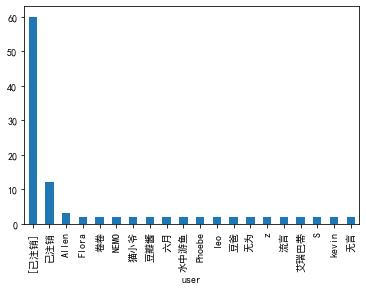

In [13]:
# 可视化-用户评论数量排序条形图
df.groupby("user")["user"].count().sort_values(ascending=False)[:20].plot.bar()

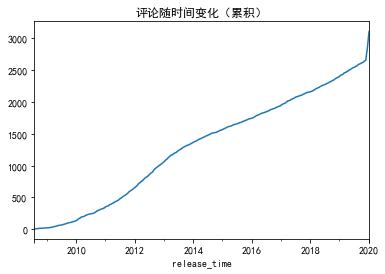

In [14]:
# 可视化-评论随时间变化（累积）
# 可以看到在2019年底，评论数量有一个较快的上升，正好这段时间电视剧庆余年电视剧播出
df_day = df.to_period('D')
df_day.groupby(df_day.index)["content"].count().cumsum().plot(title='评论随时间变化（累积）')

release_time
2008-07      1
2008-08      5
2008-09      5
2008-10      2
2008-11      2
2008-12      4
2009-01      4
2009-02      6
2009-03      9
2009-04     10
2009-05     11
2009-06      3
2009-07     12
2009-08     12
2009-09     11
2009-10     10
2009-11     11
2009-12     15
2010-01     27
2010-02     24
2010-03     12
2010-04     18
2010-05     16
2010-06     11
2010-07      5
2010-08     23
2010-09     22
2010-10     19
2010-11     11
2010-12     23
          ... 
2017-08     16
2017-09     15
2017-10     19
2017-11     14
2017-12     11
2018-01     15
2018-02     19
2018-03     21
2018-04     20
2018-05     22
2018-06     16
2018-07     16
2018-08     25
2018-09     17
2018-10     23
2018-11     25
2018-12     23
2019-01     25
2019-02     27
2019-03     20
2019-04     24
2019-05     23
2019-06     21
2019-07     24
2019-08     27
2019-09     16
2019-10     24
2019-11     73
2019-12    348
2020-01     56
Freq: M, Name: content, Length: 139, dtype: int64


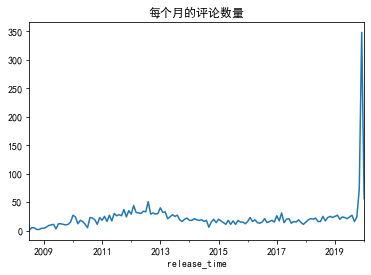

In [15]:
# 每个月的评论数量
# 以往每个月的评论条数在50条以下，2019年11 12 月超过了50条，12月最多有超过三百条
df_day = df.to_period('M')
print(df_day.groupby(df_day.index)["content"].count())
df_day.groupby(df_day.index)["content"].count().plot(title="每个月的评论数量")

In [16]:
# 对高赞评论进行排序
df.sort_values(by="vote", ascending=False)[:50]

,vote,user,user_url,star,level,content
release_time,,,,,,
2013-06-10,335,水湄物语,https://www.douban.com/people/foxsshome/,20.0,较差,@棠华 完全不好看啊，我不喜欢这种天纵奇才的设定，武功天下无敌，背景深不可测，加上英俊无比...
2015-08-28,304,鱼丸粗面,https://www.douban.com/people/sampaning/,30.0,还行,YY的连我这看书的人都有点不好意思了，上来就无耻地穿越到小孩身上（人小鬼大），还身怀天脉，过...
2015-06-29,189,川总,https://www.douban.com/people/reflect/,10.0,很差,难负盛名，废话连篇
2013-10-06,188,时间.世界,https://www.douban.com/people/1998897/,20.0,较差,1星半。
2016-12-07,71,贝利撒留.ape,https://www.douban.com/people/43340854/,50.0,力荐,发现一个神奇的现象，给这本网络小说打低分并给予负面评价的网友里，很多都给按他们的标准更差的小...
2013-09-15,64,红药石,https://www.douban.com/people/hongyaoshi/,20.0,较差,看过，中途弃书，作者一看就是个喜欢YY的男生，左右逢源，集万千高富美宠爱于一身，此等设定让我...
2010-02-05,64,苦茶,https://www.douban.com/people/Wangtanzhi/,20.0,较差,语言粗糙，故事混乱。不值得推荐。看了近一半之后，废弃不观。
2014-06-30,59,恶魔奶爸Sam,https://www.douban.com/people/Q598176297/,30.0,还行,主角太讨人厌，看了一半看不下去了，搜了下结局，剧透的连底裤都透掉了，继承了猫腻一如既往结尾不...
2015-06-12,39,喵咪,https://www.douban.com/people/42444039/,20.0,较差,根本看不下去，完全不明白为什么好评那么多……


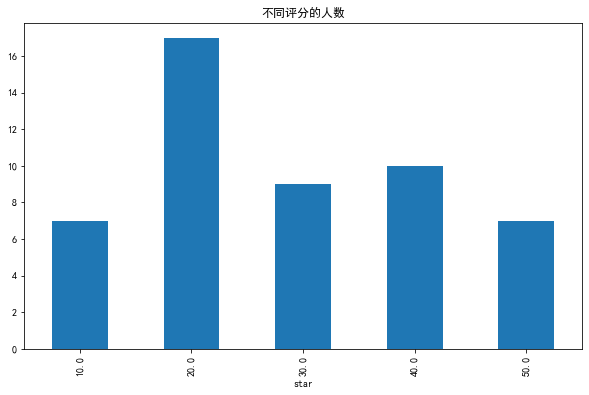

In [17]:
# 高赞的50个评论的评分等级绘制为条形图
df.sort_values(by="vote", ascending=False)[:50].groupby("star")["star"].count()\
  .plot.bar(title="不同评分的人数", figsize=(10, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123078898>],
      dtype=object)

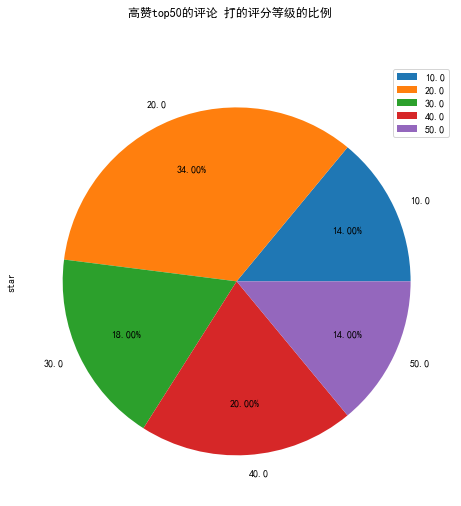

In [18]:
# 40~50 分占比34%，低分居多
df.sort_values(by="vote", ascending=False)[:50].groupby("star")["star"].count().plot.pie(figsize=(8, 8), subplots=True, autopct="%.2f%%",
                    legend=True, title="高赞top50的评论 打的评分等级的比例", labeldistance=1.1,pctdistance=0.7)

In [19]:
# 根据评分划分情感倾向
# 低于等于30的为负面倾向，用0表示
# 高于30的为正面倾向，用1表示
df.loc[df["star"] <= 30,'sentiment'] = 0
df.loc[df["star"] > 30,'sentiment'] = 1
df.head()

,vote,user,user_url,star,level,content,sentiment
release_time,,,,,,,
2020-01-06,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,喜欢那个打黑拳！！,1.0
2020-01-06,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,还可以吧。,0.0
2020-01-06,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0
2020-01-06,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0
2020-01-06,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,适合消遣看看，破梗废话太多……,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1231eef98>],
      dtype=object)

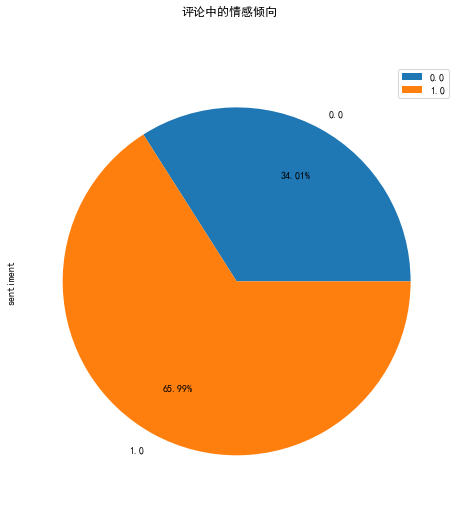

In [20]:
# 0 负面倾向
# 1 正面倾向
# 正负样本的比例为65：34，可以说是比较平衡了
df.groupby("sentiment")["sentiment"].count().plot.pie(figsize=(8, 8), subplots=True, autopct="%.2f%%",
                    legend=True, title="评论中的情感倾向", labeldistance=1.1,pctdistance=0.7)

In [21]:
# 两种分词函数，均未使用停用词
def space_cut(intxt):  # 使用空格隔开
    return " ".join([w for w in jieba.cut(intxt)])
def list_cut(intxt):  # 使用列表表示
    return [w for w in jieba.cut(intxt)]

# 将语料content分词
# 参见：https://github.com/fxsjy/jieba
df["cut"] = df["content"].apply(space_cut)
df.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/wq/03z5h7352159jp2k5p83ts500000gn/T/jieba.cache
Loading model cost 0.917 seconds.
Prefix dict has been built successfully.


,vote,user,user_url,star,level,content,sentiment,cut
release_time,,,,,,,,
2020-01-06,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,喜欢那个打黑拳！！,1.0,喜欢 那个 打黑 拳 ！ ！
2020-01-06,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,还可以吧。,0.0,还 可以 吧 。
2020-01-06,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0,其实 已经 一口气 狂 看到 了 第七卷 。 前半 的 节奏 还是 意气风发 无往不利 ， ...
2020-01-06,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0,2020 年头 的 几天 假期 啥事 没干 ， 就 看 这 几百万 字 了 。 真的 要 戒...
2020-01-06,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,适合消遣看看，破梗废话太多……,0.0,适合 消遣 看看 ， 破梗 废话 太 多 … …


In [22]:
# 结果预处理之后，再次查看缺失值情况，可以用于正常训练
df.isnull().sum(axis=0)

vote         0
user         0
user_url     0
star         0
level        0
content      0
sentiment    0
cut          0
dtype: int64

In [47]:
cs = df[["content", "sentiment"]].reset_index()
cs = cs[["content", "sentiment"]]
cs.to_csv("cs.csv")

/Users/nick/.venv/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


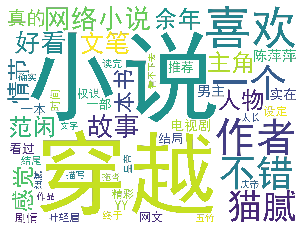

In [24]:
# 绘制词云
# 设置字体字体
myfont = "../../StaticFile/SimHei.ttf"
# myfont = "SimHei.ttf"
# 加载停用词，停用词就是在绘制词云中忽略的没有意义的词
stoplistdf = pd.read_csv('停用词.txt', names=["w"], sep="aaa", encoding="utf-8")
stoplist_wdc = list(stoplistdf.w)

# 词云 将所有的帖子进行分词-拼接起来-统计词频-展示词云
gennerate_string = ""
for c in df["cut"]:
    gennerate_string += c

# 生成词云对象
cloudobj = wordcloud.WordCloud(font_path = myfont, 
    width = 2000, height = 1500, max_words = 50,
    mode = "RGBA", background_color = None,
    stopwords = stoplist_wdc, collocations=False).generate(gennerate_string)  

# 展示图像
plt.imshow(cloudobj)
plt.axis("off")
plt.show()

In [25]:
# 构建新的表，只包含分词后的文本内容
cut_data = pd.DataFrame(df[["cut", "sentiment"]])
cut_data = cut_data.reset_index()
cut_data = cut_data.drop(["release_time"], axis=1)
cut_data.head()

,cut,sentiment
0,喜欢 那个 打黑 拳 ！ ！,1.0
1,还 可以 吧 。,0.0
2,其实 已经 一口气 狂 看到 了 第七卷 。 前半 的 节奏 还是 意气风发 无往不利 ， ...,1.0
3,2020 年头 的 几天 假期 啥事 没干 ， 就 看 这 几百万 字 了 。 真的 要 戒...,0.0
4,适合 消遣 看看 ， 破梗 废话 太 多 … …,0.0


In [26]:
# 随机划分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(cut_data["cut"], cut_data["sentiment"], test_size=0.3, random_state=30)

In [27]:
# 训练集-特征值
x_train.head()

899     平平淡淡 地 讲 了 一个 故事 ， 内容 却触 人 心弦 。 想 赶快 看 下 一章 ， ...
2488                          昏天黑地 的 看 了 两个 星期 终于 看 完 了 。
2977    宫廷 斗争 ， 可是 我 看起来 觉得 好闷 啊 ~ ~ 虽然 斗争 很 激烈 ！ 猫腻 写...
2307               很 好看 ， 就是 挺长 的 。 范闲 ， 一个 万能 的 人 ， 我 觉得
2948    09 年 看 的 最好 的 一部 书 ！ 不枉 我 用 手机 看 的 眼睛 酸痛 啊 ， 大...
Name: cut, dtype: object

In [28]:
# 训练集-标签值
y_train.head()

899     1.0
2488    1.0
2977    0.0
2307    1.0
2948    1.0
Name: sentiment, dtype: float64

In [29]:
# 词袋模型-矩阵
# 将文本数据转换为向量化的矩阵数据，后续便于进行训练
# 参考：https://www.jianshu.com/p/dcc27a28b3f4
vect = CountVectorizer()
x_train_vect = vect.fit_transform(x_train)
x_test_vect = vect.transform(x_test)
print(x_train_vect.shape)

(2177, 6692)


In [30]:
# 矩阵形式的数据如下
x_train_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
# tfidf-矩阵
# 对比词袋模型模型，是不同的向量化方法
# 将文本数据转换为向量化的矩阵数据，后续便于进行训练
# 参考：https://www.jianshu.com/p/dcc27a28b3f4
transf = TfidfTransformer()
x_train_tfidf = transf.fit_transform(x_train_vect)
x_test_tfidf = transf.transform(x_test_vect)
print(x_train_tfidf.todense().shape)  # print(vect.vocabulary_)

(2177, 6692)


In [32]:
x_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 使用词袋模型训练

In [33]:
# 使用词袋模型向量化后的数据，用朴素贝叶斯算法训练情感分类模型
nbmodel_cv = naive_bayes.MultinomialNB()
# 训练得到模型 nbmodel
nbmodel_cv.fit(x_train_vect, y_train)
# 预测
y_predict = nbmodel_cv.predict(x_test_vect)
# 输出预测准确率
train_score = nbmodel_cv.score(x_train_vect, y_train)
test_score = nbmodel_cv.score(x_test_vect, y_test)

print("【词袋模型-朴素贝叶斯】训练准确率: {} 测试准确率: {}".format(train_score, test_score))

【词袋模型-朴素贝叶斯】训练准确率: 0.9150206706476803 测试准确率: 0.7537473233404711


In [34]:
# 计算AUC值（AUC是一种模型评估指标）
# 参考：https://baike.baidu.com/item/AUC/19282953?fr=aladdin
y_prob = nbmodel_cv.predict_proba(x_test_vect)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("AUC: {}".format(auc_value))  # 这里0.74说明模型有一定的分类能力了

AUC: 0.744622410664167


In [35]:
# KS值表示了模型将+和-区分开来的能力。值越大，模型的预测准确性越好。一般，KS>0.2即可认为模型有比较好的预测准确性。
# 参考：http://cda.pinggu.org/view/21012.html
ks = max(tpr-fpr)
print("KS: {}".format(ks))  # 这里接近0.4的ks值，说明模型对正负样本具备区分能力

KS: 0.39420577351724595


In [36]:
item_cv = {
    "算法": "朴素贝叶斯",
    "向量化方法": "词袋模型",
    "训练准确率": train_score,
    "测试准确率": test_score,
    "AUC": auc_value,
    "KS": ks,
}
item_cv

{'算法': '朴素贝叶斯',
 '向量化方法': '词袋模型',
 '训练准确率': 0.9150206706476803,
 '测试准确率': 0.7537473233404711,
 'AUC': 0.744622410664167,
 'KS': 0.39420577351724595}

## 使用TF-IDF训练

In [37]:
# 使用词袋模型向量化后的数据，用朴素贝叶斯算法训练情感分类模型
nbmodel_tf = naive_bayes.MultinomialNB()
# 训练得到模型 nbmodel
nbmodel_tf.fit(x_train_tfidf, y_train)
# 预测
y_predict = nbmodel_tf.predict(x_test_tfidf)
# 输出预测准确率
train_score = nbmodel_tf.score(x_train_tfidf, y_train)
test_score = nbmodel_tf.score(x_test_tfidf, y_test)

print("【TFIDF-朴素贝叶斯】训练准确率: {} 测试准确率: {}".format(train_score, test_score))

【TFIDF-朴素贝叶斯】训练准确率: 0.8451998162609095 测试准确率: 0.7430406852248393


In [38]:
# 计算AUC值（AUC是一种模型评估指标）
# 参考：https://baike.baidu.com/item/AUC/19282953?fr=aladdin
y_prob = nbmodel_tf.predict_proba(x_test_tfidf)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("AUC: {}".format(auc_value))  # 这里0.74说明模型有一定的分类能力了

AUC: 0.7530832238831998


In [39]:
# KS值表示了模型将+和-区分开来的能力。值越大，模型的预测准确性越好。一般，KS>0.2即可认为模型有比较好的预测准确性。
# 参考：http://cda.pinggu.org/view/21012.html
ks = max(tpr-fpr)
print("KS: {}".format(ks))  # 这里接近0.4的ks值，说明模型对正负样本具备区分能力

KS: 0.3802324884328013


In [40]:
item_tf = {
    "算法": "朴素贝叶斯",
    "向量化方法": "TF-IDF",
    "训练准确率": train_score,
    "测试准确率": test_score,
    "AUC": auc_value,
    "KS": ks,
}
item_tf

{'算法': '朴素贝叶斯',
 '向量化方法': 'TF-IDF',
 '训练准确率': 0.8451998162609095,
 '测试准确率': 0.7430406852248393,
 'AUC': 0.7530832238831998,
 'KS': 0.3802324884328013}

## 对比训练结果

In [41]:
pd.DataFrame([item_cv, item_tf])

,AUC,KS,向量化方法,测试准确率,算法,训练准确率
0,0.744622,0.394206,词袋模型,0.753747,朴素贝叶斯,0.915021
1,0.753083,0.380232,TF-IDF,0.743041,朴素贝叶斯,0.845200


## 生成测试集结果

In [42]:
# 这里使用测试样本，对其进行预测，并将 文本-预测结果-真实结果 合并到一个表中进行对比
y_predict = nbmodel_cv.predict(x_test_vect)
result = pd.DataFrame(x_test)
result["sentiment_predict"] = y_predict
result["sentiment_real"] = y_test
result = result.reset_index()
result = result.drop(["index"], axis=1)
result

,cut,sentiment_predict,sentiment_real
0,叹 小 叶子 这么 强大 的 工科 女博士 也 被 爱情 击败 了,1.0,1.0
1,鹦鹉 史航 说 这 是 他 “ 最 喜欢 的 网络 穿越 小说 ” 。 他 喜欢 的 ， 大...,1.0,1.0
2,第一本 ， 真的 很 不错,1.0,1.0
3,庆 余年 一路 彩虹 将夜 这 类书 看 了 好多 ~ 月关 和 猫...,1.0,1.0
4,从头到尾 读完 了 ， 还是 很 精彩 的 。 大局 其实 一般 ， 但 有 几段 重头戏 ...,1.0,1.0
5,我 真的 不 适合 读 男频 ， 特别 是 那种 不是 1v1 的,0.0,1.0
6,看 了 四遍,1.0,1.0
7,个人 认为 很 强大 的 一 本书 。,1.0,1.0
8,打发 无聊 时间 都 觉得 无聊 。 1 ） 不 喜欢 弱智 的 人物 对话 2 ） 不 喜...,0.0,0.0
9,什么 鬼 ， 弃 了,1.0,0.0


## 输入单句预测情感倾向

In [43]:
# 选取一句书评进行分析
def analyse_comment(verify_text):
    verify_text_cut = " ".join(jieba.lcut(verify_text))
    verify_text_serise = pd.Series([verify_text_cut])
    verify_text_vect = vect.transform(verify_text_serise)
    y_predict = nbmodel_cv.predict(verify_text_vect)
    classifier = int(y_predict[0])
    if classifier == 1:
        classifier = "积极"
    else:
        classifier = "悲观"
    pd_dict = {"文本": verify_text, "情感倾向": classifier}
    return pd.DataFrame(pd_dict, index = [0])

In [44]:
text = "有别于一般穿越小说，值得一读"
result_df = analyse_comment(text)
result_df

,文本,情感倾向
0,有别于一般穿越小说，值得一读,积极
